# Fraud Detector for Credit Card Transaction

## Import Packages and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import math

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (recall_score,  
                             classification_report)
from sklearn.ensemble import RandomForestClassifier

m_font = {'fontname':'Montserrat'}

In [2]:
# Read dataset from "https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code"
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In [3]:
# Check missing values in dataframe
count = 0
for i in df.columns:
    if df[i].isnull().sum() == 0:
        continue;
    else:
        count += 1
if count > 0:
    print('Missing value has been found')
else:
    print('No missing values')

No missing values


In [4]:
data = df['Class'].value_counts()
data

0    284315
1       492
Name: Class, dtype: int64

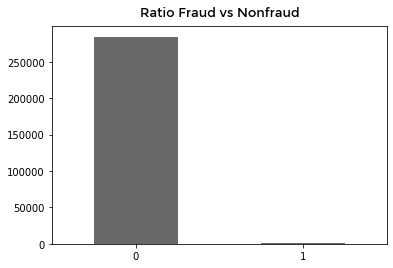

In [5]:
# Plot Data
data.plot(kind='bar', color='dimgray')

plt.xticks(rotation = 0)
plt.title('Ratio Fraud vs Nonfraud', fontsize=13, pad=10, **m_font)
plt.show();

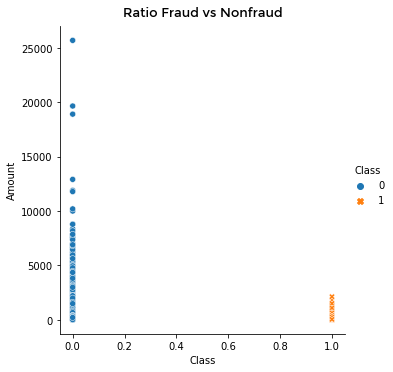

In [6]:
# Plot specifically each different class
sn.relplot(
    data=df, x=df['Class'], y=df['Amount'],
    style="Class", hue="Class",
    kind="scatter"
)
plt.title('Ratio Fraud vs Nonfraud', fontsize=13, pad=10, **m_font)
plt.show();

In [7]:
print(f'Ratio Fraud and Nonfraud --> 1 : {round(data[0]/data[1])}')

Ratio Fraud and Nonfraud --> 1 : 578


## Weighted Sample
I learned this sampling method from Tatev Karen. Go check it out!<br>
https://towardsdatascience.com/data-sampling-methods-in-python-a4400628ea1b

In [8]:
def get_weighted_sample(df,n):
    def get_class_prob(x):
        weight_x = int(np.rint(n * len(x[x.Class != 1]) / len(df[df.Class != 1])))
        sampled_x = x.sample(weight_x, random_state=2).reset_index(drop=True)
        return (sampled_x)
        # we are grouping by the target class we use for the proportions

    weighted_sample = df.groupby('Class').apply(get_class_prob)
    print(weighted_sample["Class"].value_counts())
    return weighted_sample

In [9]:
# Data sampling for Nonfraud class
class_1 = df[df['Class'] == 1]
sample = get_weighted_sample(df, class_1.shape[0])

0    492
Name: Class, dtype: int64


In [10]:
final_dataset = pd.concat([sample, class_1])
final_dataset['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

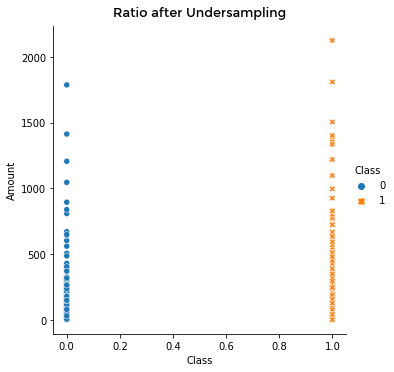

In [11]:
# Plot data dispersion
sn.relplot(
    data=final_dataset, x=final_dataset['Class'], y=final_dataset['Amount'],
    style="Class", hue="Class",
    kind="scatter"
)
plt.title('Ratio after Undersampling', fontsize=13, pad=10, **m_font)
plt.show();

## Train Test Split

In [12]:
X = final_dataset.drop('Class', axis=1)
y = final_dataset['Class']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=200)

## Random Forest Classifier Model

In [14]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train);

In [15]:
y_pred_rf = rf_model.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        99
           1       0.93      0.91      0.92        98

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197



In [17]:
print(f'Recall Score on Random Forest Model: {round(recall_score(y_test, y_pred_rf)*100,2)}%')

Recall Score on Random Forest Model: 90.82%


## Cross Validation Recall Score

In [18]:
print(f'Cross Validation Score: {round(np.mean(cross_val_score(rf_model, X_train, y_train, cv=10, scoring="recall"))*100,2)}%')

Cross Validation Score: 90.38%
